<a id=top-page></a>

# Integrate `pykitPIV` with `LIMA`

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#synthetic-images">Generate synthetic images with pykitPIV</a></li>
        <ul>
        <li><a href="#synthetic-images-training-set">Training set</a></li>
        <li><a href="#synthetic-images-testing-set">Testing set</a></li>
        </ul>
    <li><a href="#train-LIMA">Train LIMA with the generated images</a></li>
        <ul>
        <li><a href="#train-LIMA-input-data">Prepare input dataset for LIMA</a></li>
        <li><a href="#train-LIMA-train">Begin training</a></li>
        </ul>
</ol>
<p></p>
</div>
<br>

***

In [1]:
import argparse
import os
import time
import pytorch_lightning as pl
import torchvision.transforms
from rich import print
from torch.utils.data import DataLoader
import lima
import glob
import h5py
import skimage.io as io
import torch
from torch.utils.data import Dataset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
from pykitPIV import Particle, FlowField, Motion, Image

<a id=synthetic-images></a>

***

## Generate synthetic images with `pykitPIV`

[Go to the top](#top-page)

In [ ]:
image_size = (140,200)

In [ ]:
size_buffer = 10

In [ ]:
figsize = (5,3)

In [ ]:
def generate_images(n_images, random_seed):

    # Instantiate an object of the Particle class:
    particles = Particle(n_images,
                         size=image_size,
                         size_buffer=size_buffer,
                         diameters=(4,4.1),
                         distances=(1,2),
                         densities=(0.05,0.1),
                         signal_to_noise=(5,20),
                         diameter_std=0.2,
                         seeding_mode='random',
                         random_seed=random_seed)

    # Instantiate an object of the FlowField class:
    flowfield = FlowField(n_images,
                          size=image_size,
                          size_buffer=size_buffer,
                          flow_mode='random',
                          gaussian_filters=(10,11),
                          n_gaussian_filter_iter=20,
                          sin_period=(30,300),
                          displacement=(0,10),
                          random_seed=random_seed)

    # Instantiate an object of the Motion class:
    motion = Motion(particles, 
                    flowfield, 
                    time_separation=0.1)

    # Instantiate an object of the Image class:
    image = Image(random_seed=random_seed)

    # Prepare images - - - - - - - - - - - - - - - - - - 

    image.add_particles(particles)
            
    motion.forward_euler(n_steps=10)
    
    image.add_motion(motion)
    
    image.add_reflected_light(exposures=(0.6,0.65),
                              maximum_intensity=2**16-1,
                              laser_beam_thickness=1,
                              laser_over_exposure=1,
                              laser_beam_shape=0.95,
                              alpha=1/10)

    return image

<a id=synthetic-images-training-set></a>

### Training set

[Go to the top](#top-page)

The training set will have 10 image pairs:

In [ ]:
n_images = 10

We fix a random seed for generating the training set of PIV images:

In [ ]:
training_random_seed = 100

In [ ]:
image_train = generate_images(n_images, training_random_seed)

In [ ]:
image_train.plot(0,
                 instance=1,
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 cmap='Greys_r',
                 figsize=figsize);

<a id=synthetic-images-testing-set></a>

### Testing set

[Go to the top](#top-page)

The test set will have 10 image pairs:

In [ ]:
n_images = 10

We fix a random seed for generating the test set of PIV images (which is different from the random seed for the training set):

In [ ]:
test_random_seed = 200

In [ ]:
image_test = generate_images(n_images, test_random_seed)

In [ ]:
image_test.plot(0,
                instance=1,
                with_buffer=True,
                xlabel='Width [px]',
                ylabel='Height [px]',
                cmap='Greys_r',
                figsize=figsize);

In [ ]:
image_test.remove_buffers()

In [ ]:
image_test.images_I1[0].shape

In [ ]:
image_test.images_I1_no_buffer[0].shape

<a id=train-LIMA></a>
***

## Train `LIMA` with the generated images

[Go to the top](#top-page)

<a id=train-LIMA-input-data></a>
### Prepare input dataset for LIMA

[Go to the top](#top-page)

In [3]:
path = 'PIV_n3_s180_maxd10_rnd_v1.h5'

In [4]:
f = h5py.File(path, "r")

In [5]:
images = f["I"]

In [6]:
targets = f["target"]
targets = np.array(targets)[:,2:4,:,:]
# targets = targets

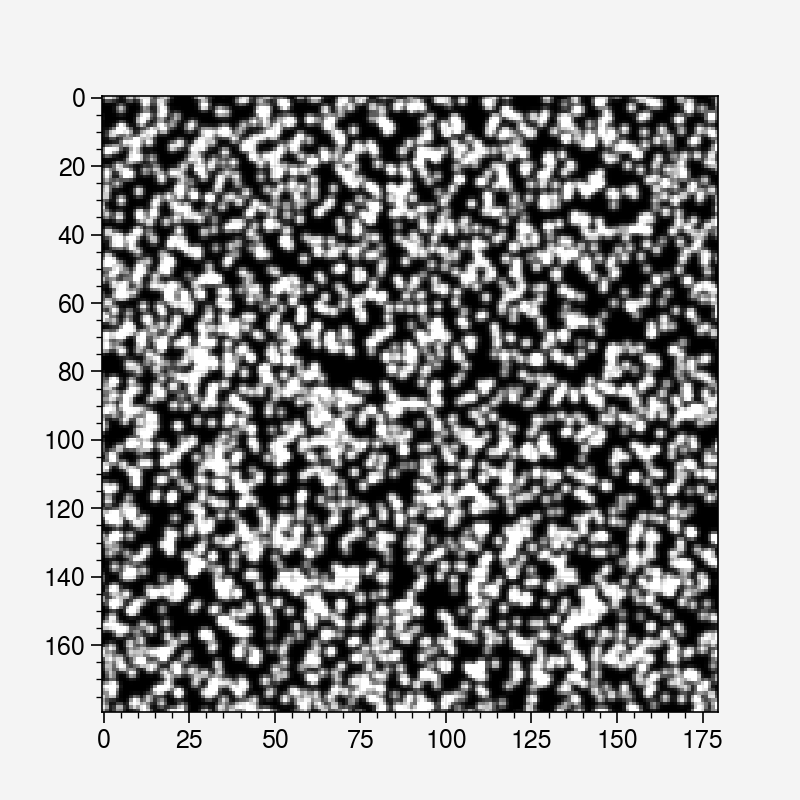

In [7]:
plt.imshow(np.array(images)[0,0,:,:], cmap='Greys_r')

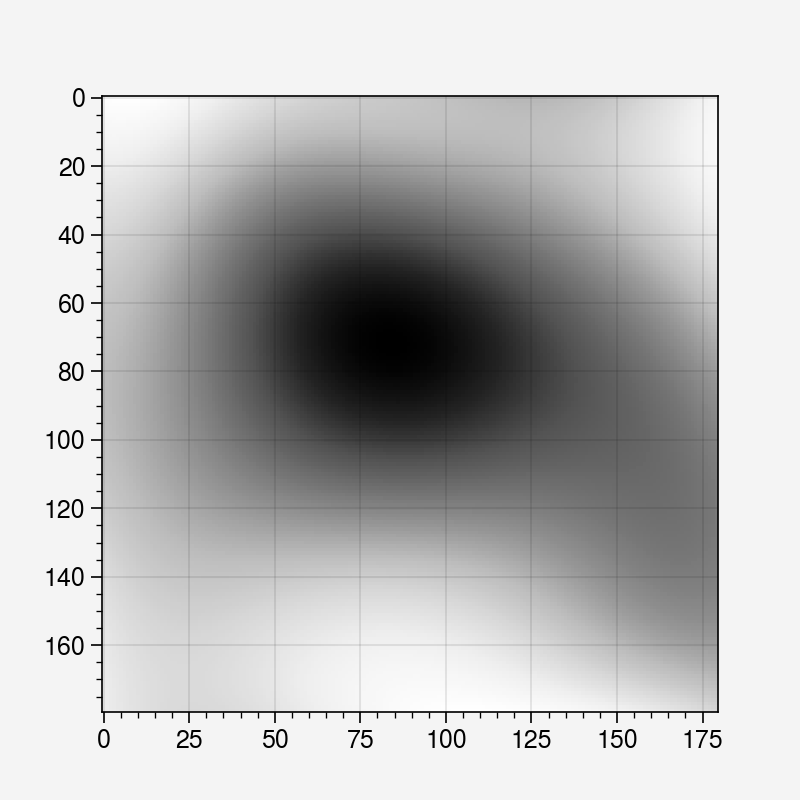

In [8]:
plt.imshow(targets[0,0,:,:], cmap='Greys_r')

In [9]:
f.close()

In [10]:
class HDF5Dataset(Dataset):
    """HDF5Dataset loaded"""

    def __init__(self, path, transform=None, n_samples=None, pin_to_ram=False):
        f = h5py.File(path, "r")
        self.data = f["I"]
        self.target = np.array(f["target"])[:,2:4,:,:]

        if n_samples:
            self.data = self.data[:n_samples]
            self.target = self.target[:n_samples]
        if pin_to_ram:
            self.data = np.array(self.data)
            self.target = np.array(self.target)
            f.close()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.data[idx], self.target[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample

In [11]:
transform = torchvision.transforms.Compose([lima.transforms.RandomAffine(degrees=17, translate=(0.2, 0.2), scale=(0.9, 2.0)),
                                            lima.transforms.RandomHorizontalFlip(),
                                            lima.transforms.RandomVerticalFlip(),
                                            lima.transforms.ToTensor(),
                                            lima.transforms.RandomBrightness(factor=(0.5, 2)),
                                            lima.transforms.RandomNoise(std=(0, 0)),])

In [12]:
train_dataset = HDF5Dataset(path=path,
                            transform=transform,)

In [13]:
test_dataset = HDF5Dataset(path=path,
                           transform=transform,)

In [14]:
train_loader = DataLoader(train_dataset,
                          batch_size=1,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True)

test_loader = DataLoader(test_dataset,
                         batch_size=1)

<a id=train-LIMA-train></a>
### Begin training

[Go to the top](#top-page)

In [15]:
random_seed = 100

In [16]:
pl.seed_everything(random_seed, workers=True)

Global seed set to 100


100

In [17]:
len_train_loader = len(train_loader)

Define the LIMA model:

In [18]:
div_flow = 0.05
loss_weights = [0.32, 0.08, 0.02, 0.01, 0.005, 0.0025, 0.00125]
search_range = 4
num_chs = [1, 16, 32, 64, 96, 128, 196]
output_level = 4
loss = 'l1_loss'
loss_weights_order = 'inc'
loss_J = 'abs'
loss_J_gamma = 1e-1
full_res = False
full_res_loss_weight_multiplier = 2.0

In [19]:
model = lima.LIMA(div_flow=div_flow,
                  loss_weights=loss_weights,
                  search_range=search_range,
                  num_chs=num_chs,
                  output_level=output_level,
                  loss=loss,
                  loss_weights_order=loss_weights_order,
                  loss_J=loss_J,
                  loss_J_gamma=loss_J_gamma,
                  full_res=full_res,
                  full_res_loss_weight_multiplier=full_res_loss_weight_multiplier,
                  epochs=10,
                  optimizer='Adam',
                  base_lr=0.01,
                  weight_decay=4e-4,
                  momentum=0.9,
                  num_workers=20,
                  beta=0.999,
                  reduction="sum",
                  scheduler='ReduceLROnPlateau',
                  lr_decay=0.2,
                  patience=10)

In [20]:
trainer = pl.Trainer(gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [21]:
trainer.fit(model,
            train_loader,
            test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                      | Type             | Params
---------------------------------------------------------------
0 | feature_pyramid_extractor | FeatureExtractor | 1.0 M 
1 | warping_layer             | WarpingLayer     | 0     
2 | flow_estimators           | ContextNetwork   | 576 K 
---------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.466     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/zdka/miniconda3/envs/lima_lento/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 100
/home/zdka/miniconda3/envs/lima_lento/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/zdka/miniconda3/envs/lima_lento/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:406: UserWarning: The number of training samples (3) is smaller than the loggin

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    13: reducing learning rate of group 0 to 2.0000e-03.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    24: reducing learning rate of group 0 to 4.0000e-04.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    35: reducing learning rate of group 0 to 8.0000e-05.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    46: reducing learning rate of group 0 to 1.6000e-05.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    57: reducing learning rate of group 0 to 3.2000e-06.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    68: reducing learning rate of group 0 to 6.4000e-07.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    79: reducing learning rate of group 0 to 1.2800e-07.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/zdka/miniconda3/envs/lima_lento/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


***